Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.157e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.871e-05 (tol = 1.000e-10) r (rel) = 1.226e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.227e-09 (tol = 1.000e-10) r (rel) = 1.339e-08 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 6.709e-16 (tol = 1.000e-10) r (rel) = 2.125e-15 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.157e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.874e-05 (tol = 1.000e-10) r (rel) = 1.227e-04 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 4.280e-09 (tol = 1.000e-10) r (rel) = 1.356e-08 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 8.159e-16 (tol = 1.000e-10) r (rel) = 2.584e-15 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iter

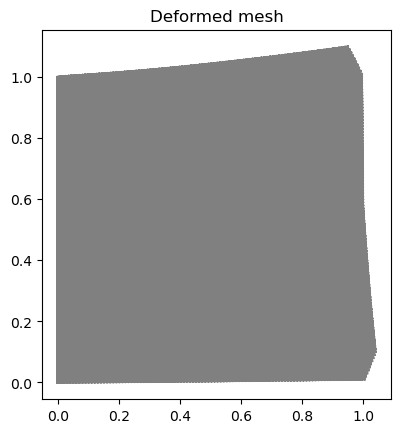

In [4]:
from dolfin import *

# Define mesh
mesh = UnitSquareMesh(100, 100)

# Define function space
V = VectorFunctionSpace(mesh, "CG", 1)

# Define material parameters
mu = Constant(1.0)  # Shear modulus
lmbda = Constant(1.0)  # Bulk modulus

x_max,x_min = mesh.coordinates().max(),mesh.coordinates().min()
y_max,y_min = mesh.coordinates().max(),mesh.coordinates().min()

# Define boundary conditions
def left_boundary(x, on_boundary):
    return near(x[0], x_min)

def right_boundary(x, on_boundary):
    return near(x[0], x_max)

bc_left = DirichletBC(V, Constant((0.0, 0.0)), left_boundary)  # Fixed displacement

# Define functions
du = TrialFunction(V)  # Incremental displacement
v = TestFunction(V)  # Test function
u = Function(V)  # Displacement from previous iteration

# Kinematics
d = u.geometric_dimension()
I = Identity(d)  # Identity tensor
F = I + grad(u)  # Deformation gradient

# Invariants of deformation tensors
C = F.T * F
Ic = tr(C)
J = det(F)

# Neo-Hookean model
psi = (mu / 2) * (Ic - 2) - mu * ln(J) + (lmbda / 2) * (ln(J))**2

# Total potential energy
Pi = psi * dx

# Compute first variation of Pi (directional derivative)
F = derivative(Pi, u, v)

# Compute Jacobian of F
Jacobian = derivative(F, u, du)

# Solve problem
problem = NonlinearVariationalProblem(F, u, bc_left, Jacobian)
solver = NonlinearVariationalSolver(problem)

# Set solver parameters (if needed)
solver.parameters["newton_solver"]["linear_solver"] = "lu"

# Incremental loading
num_steps = 10
final_deformation = 0.1  # Final imposed deformation
increment = final_deformation / num_steps

for step in range(num_steps):
    # Update right boundary condition
    bc_right = DirichletBC(V.sub(0), Expression("var", var=(step + 1) * increment, degree=1), right_boundary)
    bcs = [bc_left, bc_right]
    problem = NonlinearVariationalProblem(F, u, bcs, Jacobian)
    solver = NonlinearVariationalSolver(problem)

    # Solve problem
    solver.solve()


    # Post-process results (you can add your own code here)

    # Plot deformed configuration
    plot(u, mode="displacement")
    moved_mesh = Mesh(mesh)
    ALE.move(moved_mesh, u)

    # Plot deformed mesh
    plot(moved_mesh, title='Deformed mesh')


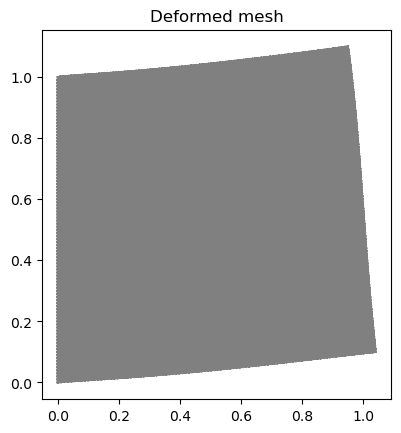

In [6]:
plot(u, mode="displacement")
moved_mesh = Mesh(mesh)
ALE.move(moved_mesh, u)

# Plot deformed mesh
plot(moved_mesh, title='Deformed mesh')